In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [30]:
%load_ext autoreload
%autoreload 2

import pubmed_landscape_src
from pubmed_landscape_src.plotting import (
    automatic_coloring,
    improved_coloring,
    years_coloring,
    plot_tsne_colors,
    plot_label_tags,
    plot_tsne_years,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [5]:
plt.style.use("matplotlib_style.txt")

# Colors

## Import data

In [32]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN = pd.read_pickle(
    variables_path / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x9454a8000 @ 
tcmalloc: large alloc 1233903616 bytes == 0x9ef4ae000 @ 


In [24]:
tsne_reparsed = np.load(variables_path / "bert/tsne_reparsed.npy")

In [25]:
tsne = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

## Colors based on journal keywords

In [20]:
"""
Description of colors and words below.

Colors:
-chosen_colors: colors chosen manually from Scanpy colors selection 
(originally from http://godsnotwheregodsnot.blogspot.com/2013/11/kmeans-color-quantization-seeding.html)

Words:
-words_capital: Words selected manually from the 100 most relevant words using threshold 0.1.
"""

# COLORS
chosen_colors = [
    "black",
    "#aeaa00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#0089A3",
    "#0000A6",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#5A0007",
    "#BA0900",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#00C2A0",
    "#549E79",
    "#BC23FF",
    "#C895C5",
    "#FF2F80",
    "#009271",
    "#00FECF",
    "#A4E804",
    "#FFB500",
    "#6B002C",
    "#FF9408",
    "#CC0744",
    "#D790FF",
    "#5B4534",
    "#E83000",
    "#6F0062",
    "#b65141",
    "#C20078",
    "#7A4900",
    "#FF90C9",
    "#6508ba",
]
# WORDS
words = [
    "cancer",
    "neuroscience",
    "cardiology",
    "ecology",
    "bioinformatics",
    "chemistry",
    "surgery",
    "environment",
    "material",
    "microbiology",
    "pediatric",
    "immunology",
    "psychology",
    "psychiatry",
    "genetics",
    "nutrition",
    "veterinary",
    "engineering",
    "education",
    "physics",
    "optics",
    "nursing",
    "neurology",
    "radiology",
    "ophthalmology",
    "gynecology",
    "rehabilitation",
    "pathology",
    "anesthesiology",
    "dermatology",
    "pharmacology",
    "physiology",
    "virology",
    "biochemistry",
    "computation",
    "infectious",
    "healthcare",
    "ethics",
]

In [21]:
colors_new_legend = dict(zip(words, chosen_colors))

In [66]:
%%time
labels_new, colors_new = improved_coloring(clean_df_updated_reparsed_filtered_with_authors_ISSN['Journal'], colors_new_legend)

CPU times: user 12min 12s, sys: 41.1 s, total: 12min 53s
Wall time: 12min 53s


In [71]:
#save results
np.save(variables_path / "colors_new", colors_new)

#save results
f = open(variables_path / "colors_new_legend.pkl","wb")
pickle.dump(colors_new_legend,f)
f.close()

### Plot

In [23]:
# load
# legend colors
pickle_in = open(variables_path / "colors_new_legend.pkl", "rb")
colors_new_legend = pickle.load(pickle_in)

colors_new = np.load(variables_path / "colors_new.npy", allow_pickle=True)

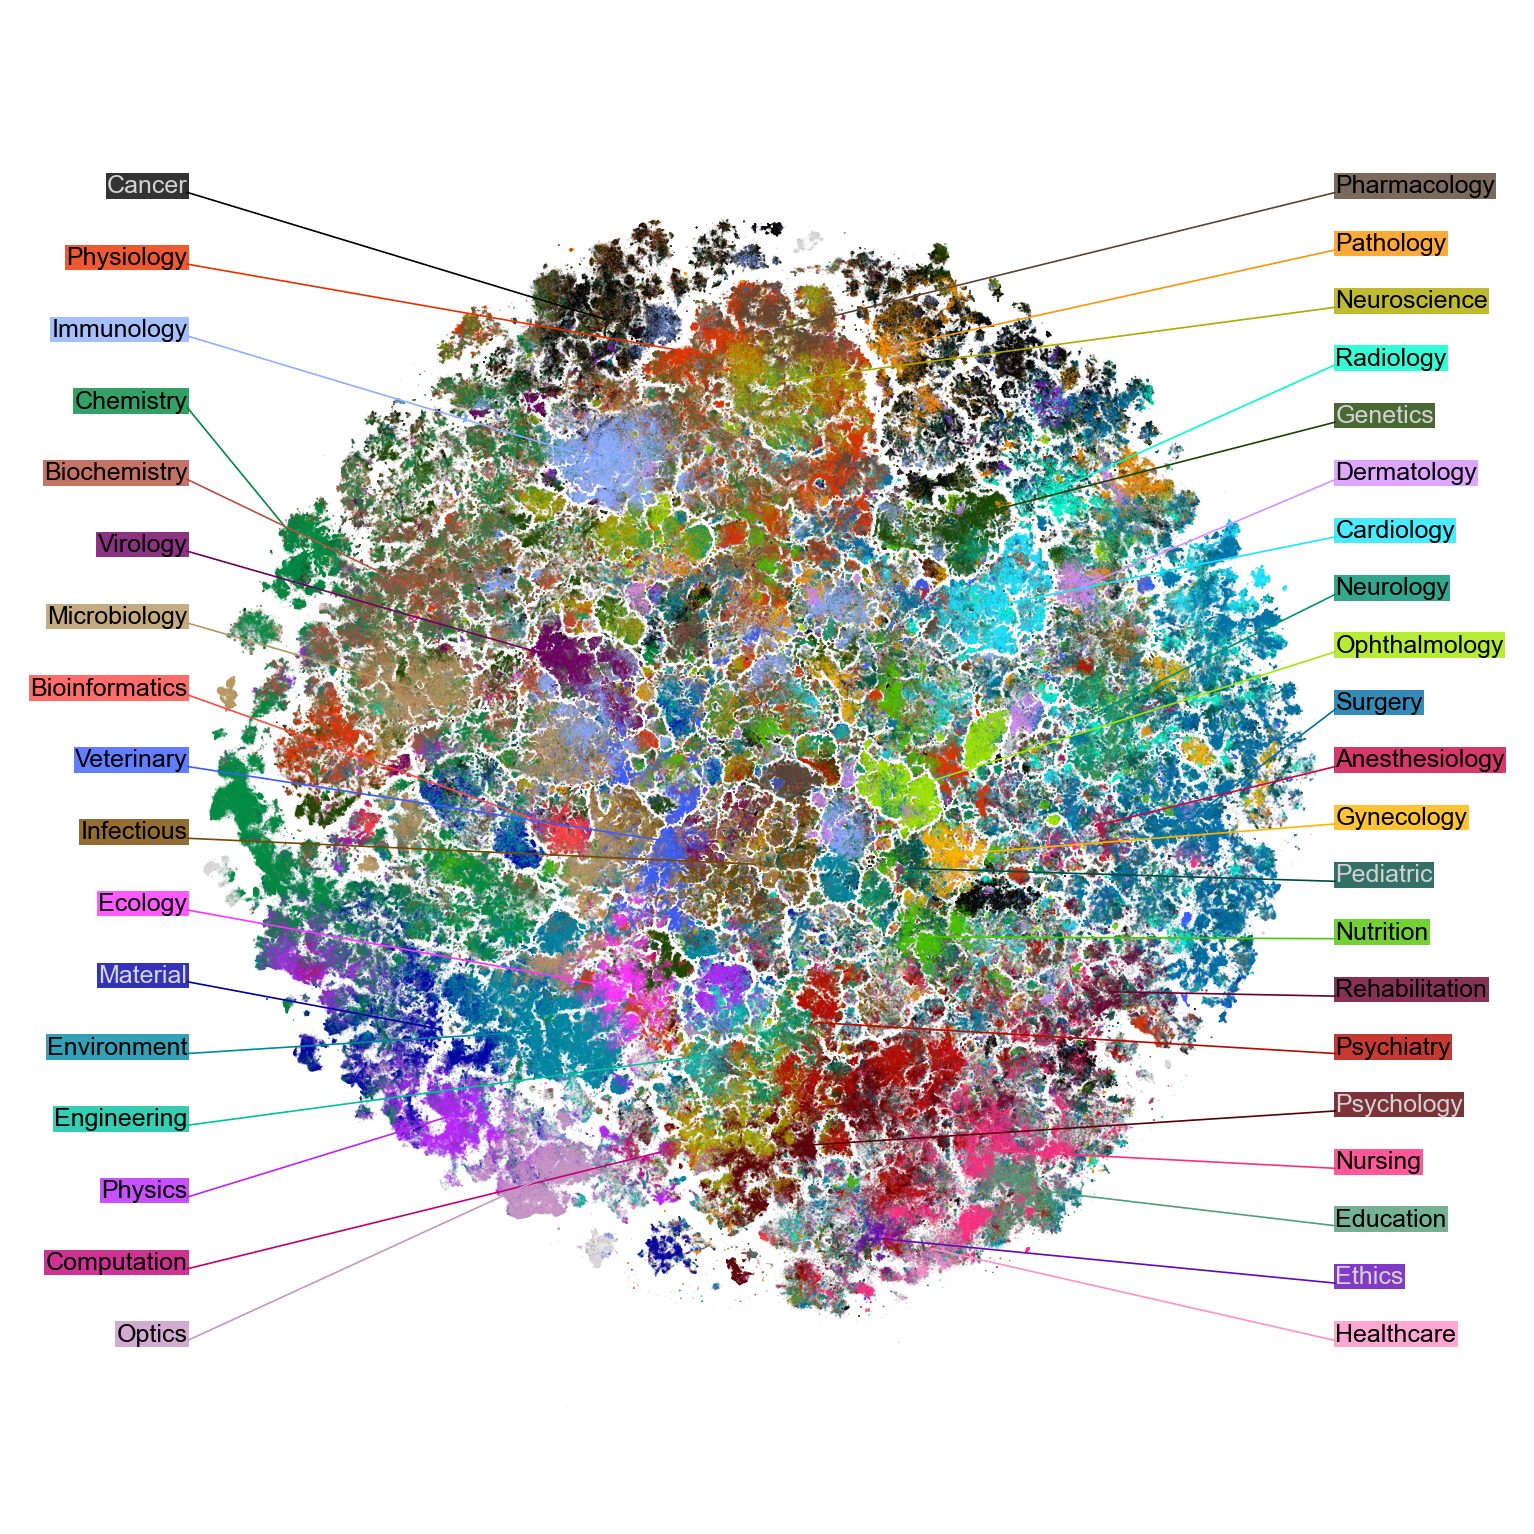

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

plot_tsne_colors(
    tsne, colors_new, x_lim=x_lim, y_lim=y_lim, ax=ax, plot_type=None
)
plot_label_tags(
    tsne,
    colors_new,
    colors_new_legend,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=ax,
    fontsize=6,
    rs=2,
)

fig.savefig(figures_path / "tsne_colored_by_labels.png", dpi=300)

## Colors by year of publication

In [33]:
# Date
all_dates = clean_df_updated_reparsed_filtered_with_authors_ISSN["Date"]
unique_dates = np.unique(all_dates)

In [34]:
# Example of how the dates look like
print(unique_dates[20000:20010])

['2008 Jun 14' '2008 Jun 15' '2008 Jun 16' '2008 Jun 17' '2008 Jun 18'
 '2008 Jun 18-24' '2008 Jun 19' '2008 Jun 20' '2008 Jun 21' '2008 Jun 22']


In [6]:
%%time

# We do this to get the vocabulary, that divides the date strings in their different words

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_dates = vectorizer.fit_transform(unique_dates)
vocabulary_dates=vectorizer.vocabulary_

CPU times: user 116 ms, sys: 3.52 ms, total: 120 ms
Wall time: 121 ms


In [7]:
dates_list=list(vocabulary_dates.keys())
len_dates_list=map(len, dates_list)
len_dates=np.fromiter(len_dates_list, dtype=np.int64,count=len(dates_list))

dates_list=np.array(dates_list)
years=dates_list[len_dates==4]
print(list(years))

['1808', '1881', '1891', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 'fall', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', 'june', 'july', '1996', '1997', '1998', '1999', '2000', '2004', '2001', '2002', '2003', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',

In [8]:
# eliminate manually the words that are not years
years = ['1808', '1881', '1891', '1896', '1897', '1898', '1899', '1900', '1901', '1902', 
 '1903', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', 
 '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', 
 '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', 
 '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', 
 '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', 
 '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', 
 '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', 
 '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', 
 '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', 
 '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', 
 '2004', '2001', '2002', '2003', '2005', '2006', '2007', '2008', '2009', '2010', 
 '2011', '2012', '2013', '2014', '2015', '2016', '2017', 
 '2018', '2019', '2020', '2021', '2022']

#save
np.save(variables_path / "years_reparsed",years)

In [9]:
# dicctionary years(number):color value

length_interval=2022-1970
cmap_values=np.linspace(0,1,length_interval+1)
year_numbers_list=np.arange(1970,2023).tolist()

dicc_years = dict(zip(year_numbers_list, cmap_values))

In [10]:
#save results
f = open(variables_path / "legend_years.pkl","wb")
pickle.dump(dicc_years,f)
f.close()

MEDLINE started its record in 1966 and later included almost 60 thousand noteworthy papers previously published. Therefore, the majority of the papers from PubMed are post 1970, so we used a color map going from blue (1970) to yellow (2022) and all of the papers dated before 1970 were also colored in the darkest hue of blue.

In [11]:
# We manually set papers dated from before 1970 to 0 (equivalent to the darkest hue).

years_out=[1808, 1881, 1891, 1896, 1897, 1898, 1899,1900, 1901, 1902, 1903, 1905, 1906, 1907, 1908, 
           1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 
           1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 
           1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 
           1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969] 

for elem in years_out:
    dicc_years[elem]=0

In [13]:
%%time

colors_per_year_reparsed, date_year = years_coloring(clean_df_updated_reparsed_filtered_with_authors_ISSN['Date'], years, dicc_years)

CPU times: user 17min 52s, sys: 24.7 s, total: 18min 17s
Wall time: 18min 17s


In [9]:
# save
np.save(variables_path / "colors_per_year_reparsed", colors_per_year_reparsed)

In [14]:
# save
np.save(variables_path / "date_year_reparsed", date_year)

### Plot

In [28]:
# save
colors_per_year_reparsed = np.load(
    variables_path / "colors_per_year_reparsed.npy"
)

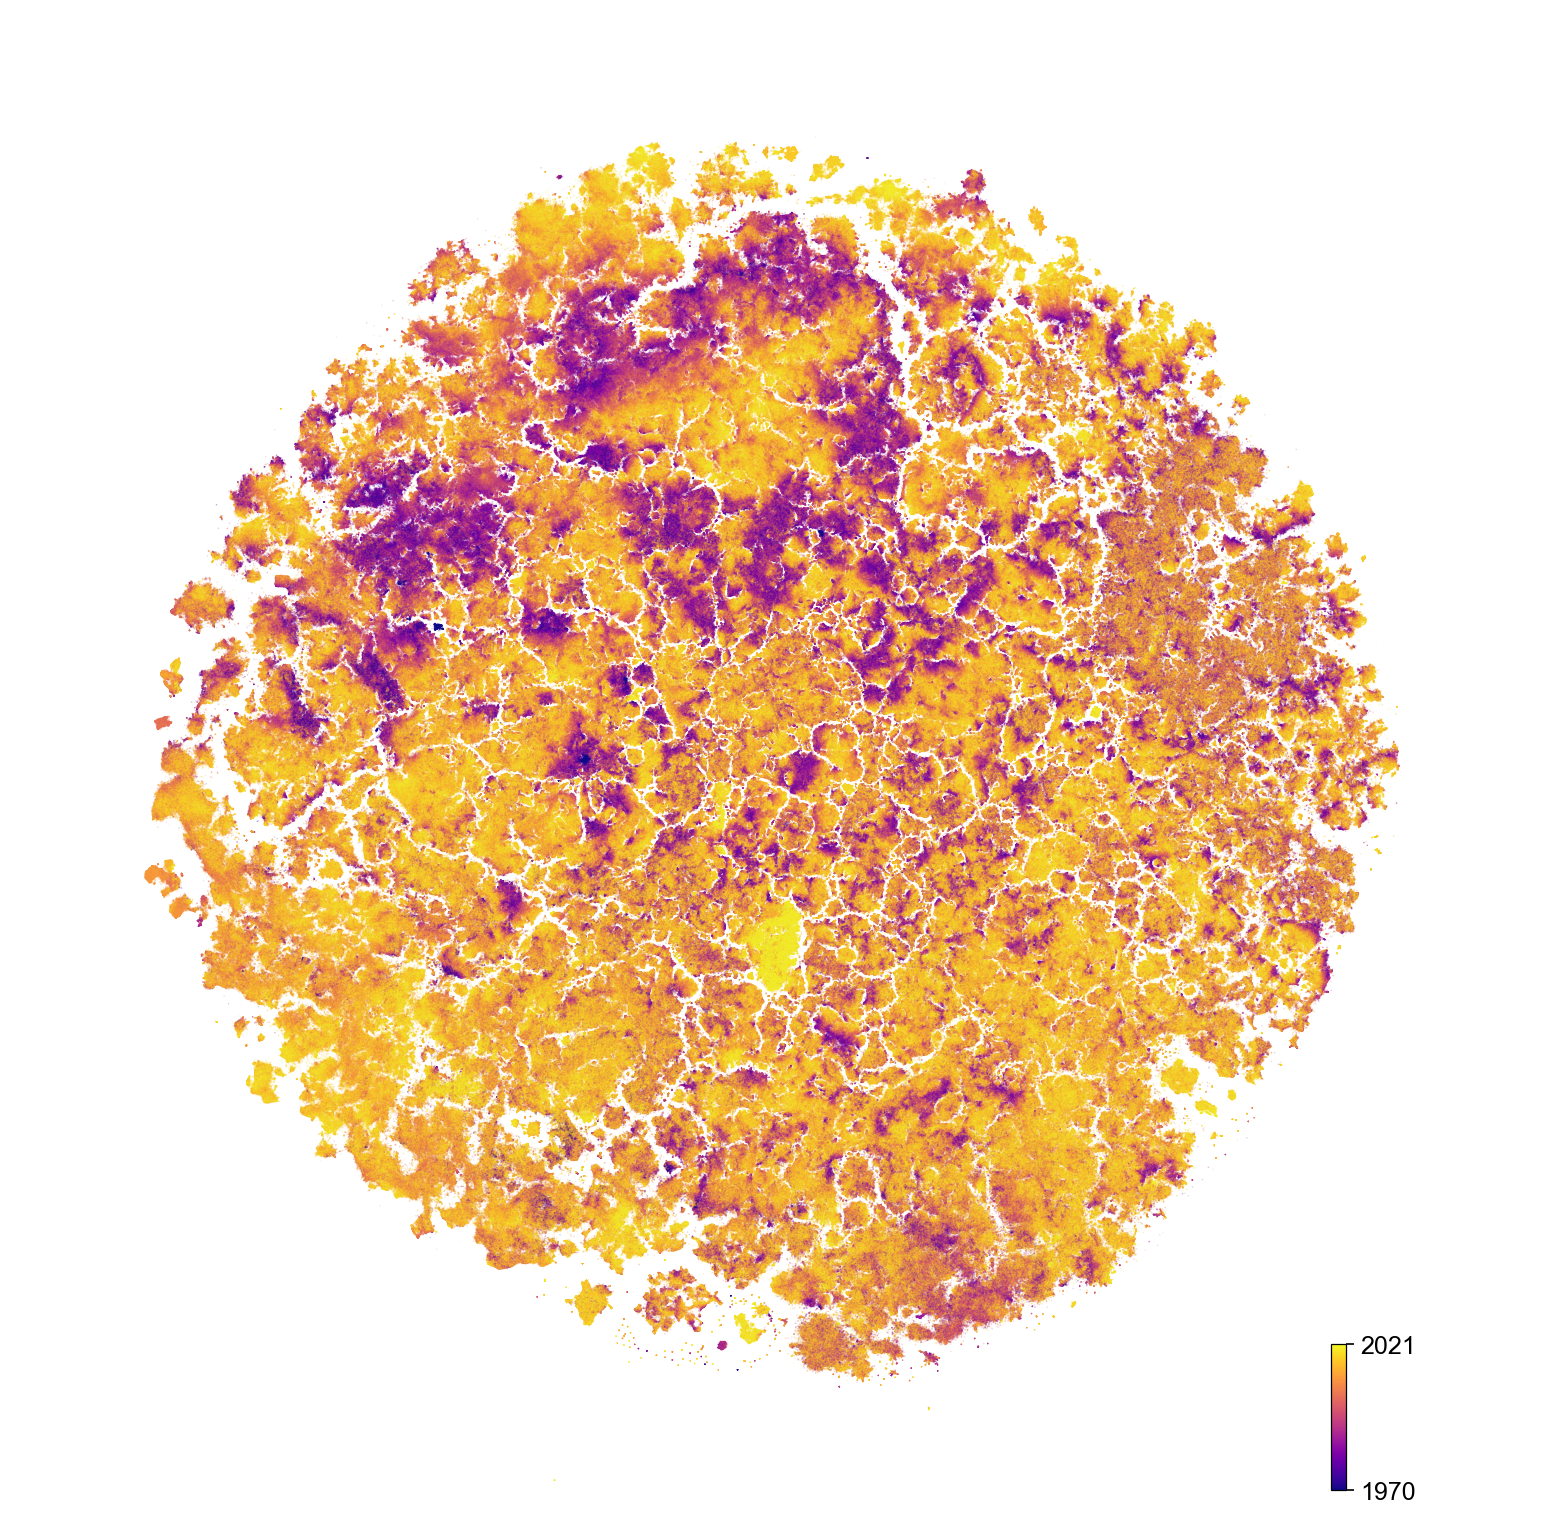

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

plot_tsne_years(
    tsne,
    colors_per_year_reparsed,
    x_lim=x_lim,
    y_lim=y_lim,
    ax=ax,
    fontsize=6,
    colorbar=True,
)

# fig.savefig(figures_path / "tsne_colored_by_years.png", dpi=300)